In [1]:
import random
from collections import defaultdict
import numpy as np
import librosa as rosa
import os
import matplotlib.pyplot as plt
from utils import set_seed

DATA_PATH = os.path.join(os.getcwd(), "data/")
model_weights_path = os.path.join(os.getcwd(), "model_weights/")
assets_path = os.path.join(os.getcwd(), "assets/")

mel_specs_path = DATA_PATH + "fma_genre_spectrograms/"
multitask_path = DATA_PATH + "multitask_dataset/"
beat_mel_specs_path = DATA_PATH + "fma_genre_spectrograms_beat/"
os.makedirs(model_weights_path, exist_ok=True)
os.makedirs(assets_path, exist_ok=True)

BATCH_SIZE = 8
VAL_SIZE = 0.33
RANDOM_SEED = 42
set_seed(RANDOM_SEED)

In [39]:
# read the label file and group audio files by genre
with open(file=mel_specs_path+"train_labels.txt", mode="r") as file:
    lines = file.readlines()
    genres = defaultdict(list)
    for i, line in enumerate(lines):
        if i==0:
            continue
        audio, genre = line.strip().split("\t")
        audio_id = audio.split(".")[0]
        genres[genre].append(audio_id)
        
# randomly select one audio file for each genre (20 genres in total)
samples = list()
for genre, audios in genres.items():
    samples.append((genre, random.choice(audios)))
    
# select two random audio samples (ensuring different genre) to visualise
specs = dict()
for sample in random.sample(samples, 2):
    audio_path = mel_specs_path+'train/'+sample[1]+".fused.full.npy"

    spec = np.load(audio_path)    
    specs[sample[1]] = {
        "genre": sample[0],
        "mel": spec[:128],
        "chroma": spec[128:],
    }
    
print(f"Chose {' & '.join(specs[key]['genre'] for key in specs)} over {len(samples)} genres")

Chose Punk & Old-Time over 20 genres


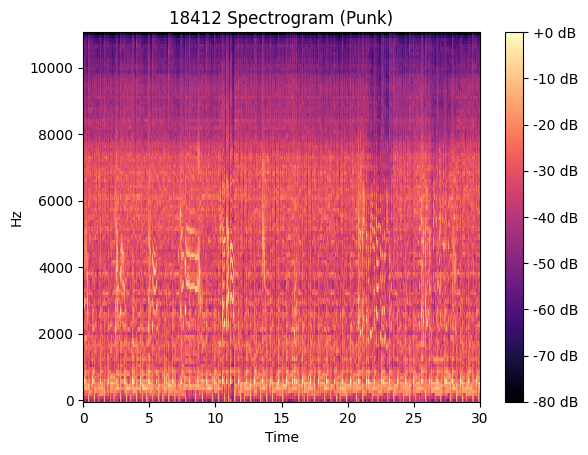

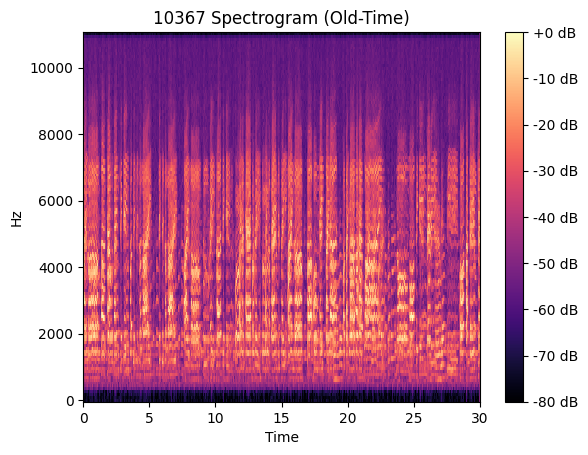

In [41]:
# Plot the spectrograms
for audio_id, info in specs.items():
    fig, ax = plt.subplots()
    img = rosa.display.specshow(info["mel"], x_axis='time', y_axis='linear', ax=ax)
    ax.set(title=f'{audio_id} Spectrogram ({info["genre"]})')
    fig.colorbar(img, ax=ax, format="%+2.f dB")

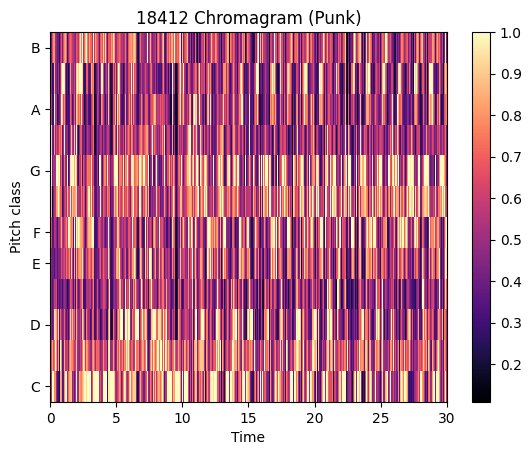

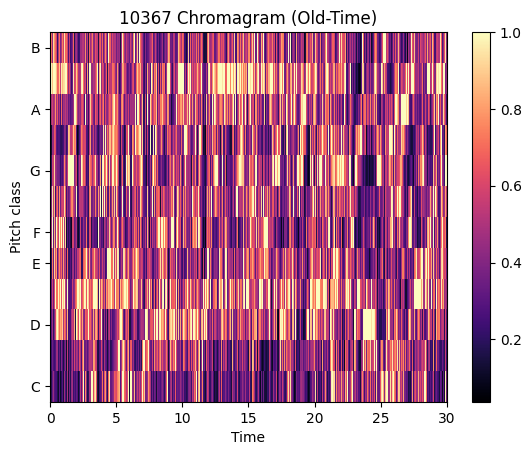

In [42]:
# Plot the chromagrams
for audio_id, info in specs.items():
    fig, ax = plt.subplots()
    img = rosa.display.specshow(info["chroma"], y_axis='chroma', x_axis='time', ax=ax)
    ax.set(title=f'{audio_id} Chromagram ({info["genre"]})')
    fig.colorbar(img, ax=ax)

In [37]:
from utils import SpectrogramDataset, CLASS_MAPPING, torch_train_val_split, set_seed

beat_mel_specs = SpectrogramDataset(
    path=beat_mel_specs_path, 
    class_mapping=CLASS_MAPPING, 
    train=True, 
    feat_type='mel', 
    max_length=-1
)
    
train_loader_beat_mel, val_loader_beat_mel = torch_train_val_split(
    dataset=beat_mel_specs, 
    batch_train=BATCH_SIZE,
    batch_eval=BATCH_SIZE, 
    val_size=VAL_SIZE
)

datum = next(iter(train_loader_beat_mel))
print('Data shape')
print(datum[0].shape)  # shape of data
print('Labels')
print(datum[1])  # labels in batch
print('Lengths')
print(datum[2])  # length of each element in batch

Data shape
torch.Size([8, 129, 128])
Labels
tensor([8, 0, 1, 8, 6, 7, 1, 8])
Lengths
tensor([54, 63, 71, 65, 47, 43, 60, 78])


In [43]:
# load the beat-synced versions of the audio files you visualised above to compare
beat_specs = dict()
for audio_id, info in specs.items():
    audio_path = beat_mel_specs_path+'train/'+audio_id+".fused.full.npy"

    spec = np.load(audio_path)    
    beat_specs[audio_id] = {
        "genre": info["genre"],
        "mel": spec[:128],
        "chroma": spec[128:],
    }

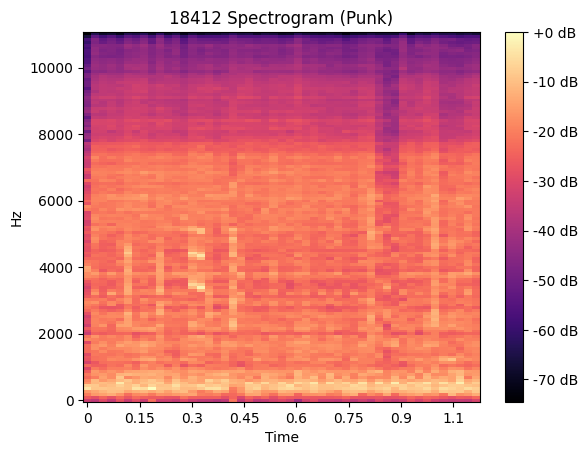

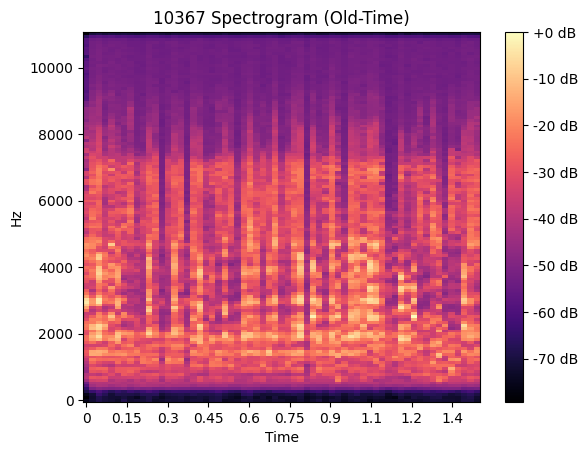

In [44]:
# plot the spectrograms
for audio_id, info in beat_specs.items():
    fig, ax = plt.subplots()
    img = rosa.display.specshow(info["mel"], x_axis='time', y_axis='linear', ax=ax)
    ax.set(title=f'{audio_id} Spectrogram ({info["genre"]})')
    fig.colorbar(img, ax=ax, format="%+2.f dB")

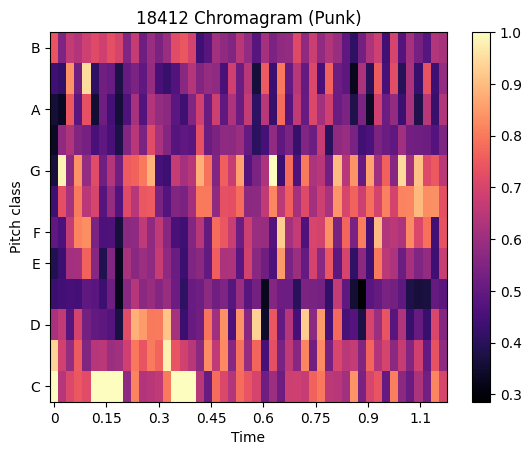

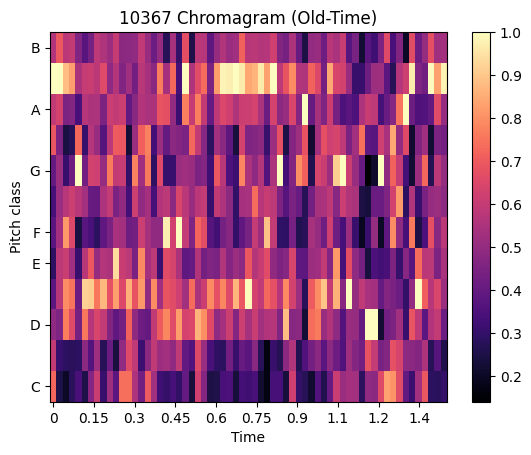

In [45]:
# plot the chromagrams
for audio_id, info in beat_specs.items():
    fig, ax = plt.subplots()
    img = rosa.display.specshow(info["chroma"], y_axis='chroma', x_axis='time', ax=ax)
    ax.set(title=f'{audio_id} Chromagram ({info["genre"]})')
    fig.colorbar(img, ax=ax)